<a href="https://colab.research.google.com/github/agi2019/ppi-gci/blob/main/tutorials/04%20-%20structural_bottlenecks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Structural bottlenecks</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>) Adapted for PPI-Global Cybersecurity Index (GCI) project on cybersecurity policy prioritisation

The previous page explained how to simulate a budgetary intervention. The results suggest that, for this example, the indicators respond modestly to linear increments in government expenditure. In this tutorial, I will explain how to expand on the idea of expenditure sensitivity in order to quantify structural bottlenecks.

## Importing Python libraries to manipulate and visualise data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Selecting Scenario

In [10]:
#scenario = '_scenario1'
scenario = '_scenario2'
#scenario = '_scenario3'

## Importing PPI functions

In [11]:
import requests
url = 'https://raw.githubusercontent.com/agi2019/ppi-gci/main/source_code/policy_priority_inference.py'
r = requests.get(url)
with open('policy_priority_inference.py', 'w') as f:
    f.write(r.text)
import policy_priority_inference as ppi

## Load data

**New disbursement schedule for simulating next 2 years, assuming that expenditure will be the same as the last period of the sample**

In [12]:
# INDICATORS
df_indis = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_indicators.csv')
N = len(df_indis) # number of indicators
I0 = df_indis.minVals.values # initial values
R = df_indis.instrumental # instrumental indicators
qm = df_indis.qm.values # quality of monitoring
rl = df_indis.rl.values # quality of the rule of law
indis_index = dict([(code, i) for i, code in enumerate(df_indis.seriesCode)]) # used to build the network matrix
Imax = df_indis.maxVals.values
Imin = df_indis.minVals.values
goals = np.random.rand(N)*(Imax - I0) + I0

# PARAMETERS
df_params = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/parameters.csv')
alphas = df_params.alpha.values
alphas_prime = df_params.alpha_prime.values
betas = df_params.beta.values

# NETWORK
df_net = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_network.csv')
A = np.zeros((N, N)) # adjacency matrix
for index, row in df_net.iterrows():
    i = indis_index[row.origin]
    j = indis_index[row.destination]
    w = row.weight
    A[i,j] = w

# DISBURSEMENT SCHEDULE (make sure that the disbursement schedule is consistent with T, otherwise PPI will simulate the T of the calibration)
T = 60
df_exp = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_expenditure.csv')
Bs_retrospective = df_exp.values[:,1::] # disbursement schedule (assumes that the expenditure programmes are properly sorted)
# Create a new disbursement schedule assuming that expenditure will be the same as the last period of the sample
Bs = np.tile(Bs_retrospective[:,-1], (T,1)).T

# RELATIONAL TABLE
df_rela = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_relational_table.csv')
B_dict = {}
for index, row in df_rela.iterrows():
    B_dict[indis_index[row.seriesCode]] = [programme for programme in row.values[1::][row.values[1::].astype(str)!='nan']]

## Bottlenecks

In the ppi book, we develop two definitions of structural bottlenecks:

1. Idiosyncratic bottlenecks: Those that focus on the structural constraints of a single indicator.
2. Systemic bottlenecks: Those that "clog" the development of other policy issues through indirect impacts.

This page will focus on the first type: <strong>idiosyncratic bottlenecks</strong>. An idiosyncratic bottleneck manifests when an indicator with a bad historical performance responds poorly to budgetary interventions. <b>An indicator may not respond to an expenditure programme because it experiences strong structural constraints that can only be lifted through long-term structural reforms (e.g., redesigning the relevant government programmes). This type of problems cannot be solved by spending more resources as the government programmes in place are likely ill-conceived.</b>


### The budgetary frontier

To identify an idiosyncratic bottleneck you need to think of a hypothetical budgetary intervention that would lift all financial obstacles and negative spillovers. Effectively, such scenario would mean that the probability of success of the intervened indicator is always 1. This hypothetical scenario is called the <strong>budgetary frontier</strong>, and was originally developed in https://doi.org/10.1007/s11625-022-01095-1. The idea is that, if a government operates on the budgetary frontier, and there are indicators that respond poorly, it means that they are being constrained by long-term structural factors.

To perform frontier analysis, the `run_ppi` function offers the optional parameter `frontier`. This parameter consists of a vector specifying the probability of success that one would like to exogenously impose to each indicator. Hence, for this tutorial, I will impose a value of 1 for all indicators at the same time. A more nuanced analysis may consider to only analyse one or a subset of indicators at a time.


### Parallelisation

Instead of calling the `run_ppi` function in an explicit `for` loop, I will use `run_ppi_parallel`, which allows to perform multiple Monte Carlo simulations and distribute their load across four cores or processors. This function takes the same inputs as `run_ppi` with a couple of additional ones to specify the number of simulations. First, I will run the baseline simulation and, then, the frontier one.

In [13]:
parallel_processes=4
sample_size=1000 # now we increase the sample size from 100 (which was used in the previous tutorial) to 1000

# first the baseline
outputs_baseline = ppi.run_ppi_parallel(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                                        Imax=Imax, Imin=Imin, Bs=Bs, B_dict=B_dict, T=T, G=goals,
                                        parallel_processes=parallel_processes, sample_size=sample_size)

# now the frontier
# notice that Bs and B_dict will be overridden by frontier
frontier = np.ones(N)
outputs_frontier = ppi.run_ppi_parallel(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                                        Imax=Imax, Imin=Imin, Bs=Bs, B_dict=B_dict, T=T, G=goals, frontier=frontier,
                                        parallel_processes=parallel_processes, sample_size=sample_size)

Now we unpack the outputs and obtain the average time series of the baseline and the counterfactual.

In [14]:
tsI_sample, tsC_sample, tsF_sample, tsP_sample, tsS_sample, tsG_sample = outputs_baseline
tsI_baseline = np.mean(tsI_sample, axis=0)

tsI_sample, tsC_sample, tsF_sample, tsP_sample, tsS_sample, tsG_sample = outputs_frontier
tsI_frontier = np.mean(tsI_sample, axis=0)

Time to visualise the difference in development gaps.

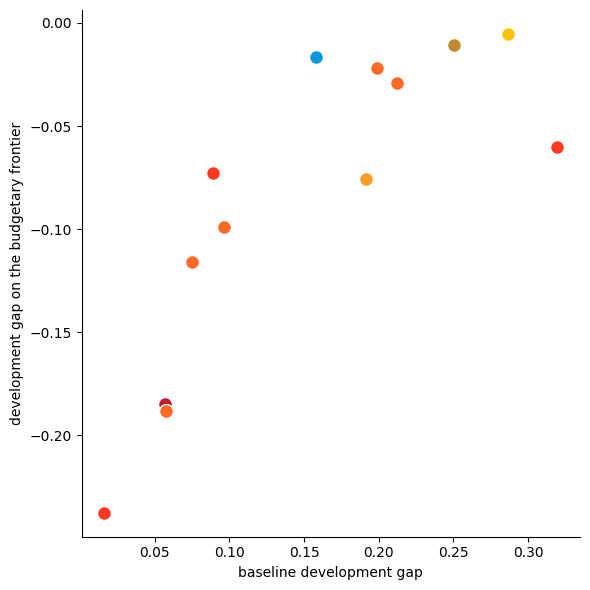

In [15]:
plt.figure(figsize=(6, 6))
for index, row in df_indis.iterrows():
    goal = goals[index]
    if goal > tsI_baseline[index,T-1]: # consider only those indicators that would not reach their goals
        plt.plot(goal-tsI_baseline[index,T-1], goal-tsI_frontier[index,T-1],
                 '.', mec='w', mfc=row.color, markersize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('baseline development gap')
plt.ylabel('development gap on the budgetary frontier')
plt.tight_layout()

Now you can see that, on the frontier, many indicators would respond by closing their gaps, or even surpassing their goals (negative values in the vertical axis). Other indicators, in contrast, still show no sensitivity to the removal of financial constraints, flagging potential bottlenecks.

The next step is to identify those policy issues that are insensitive and have shown poor performance in the historical data. The latter criterion, poor performance, can be arbitrary and context specific. For this example, I establish as the threshold of bad performance an average historical level of 0.5.

Now, let me show a scatter plot that reveals the potential idiosyncratic bottlenecks. The plot shows the historical performance of each indicator against the fraction of the development gap that is closed when operating on the budgetary frontier. I colour the bottleneck area in gray.

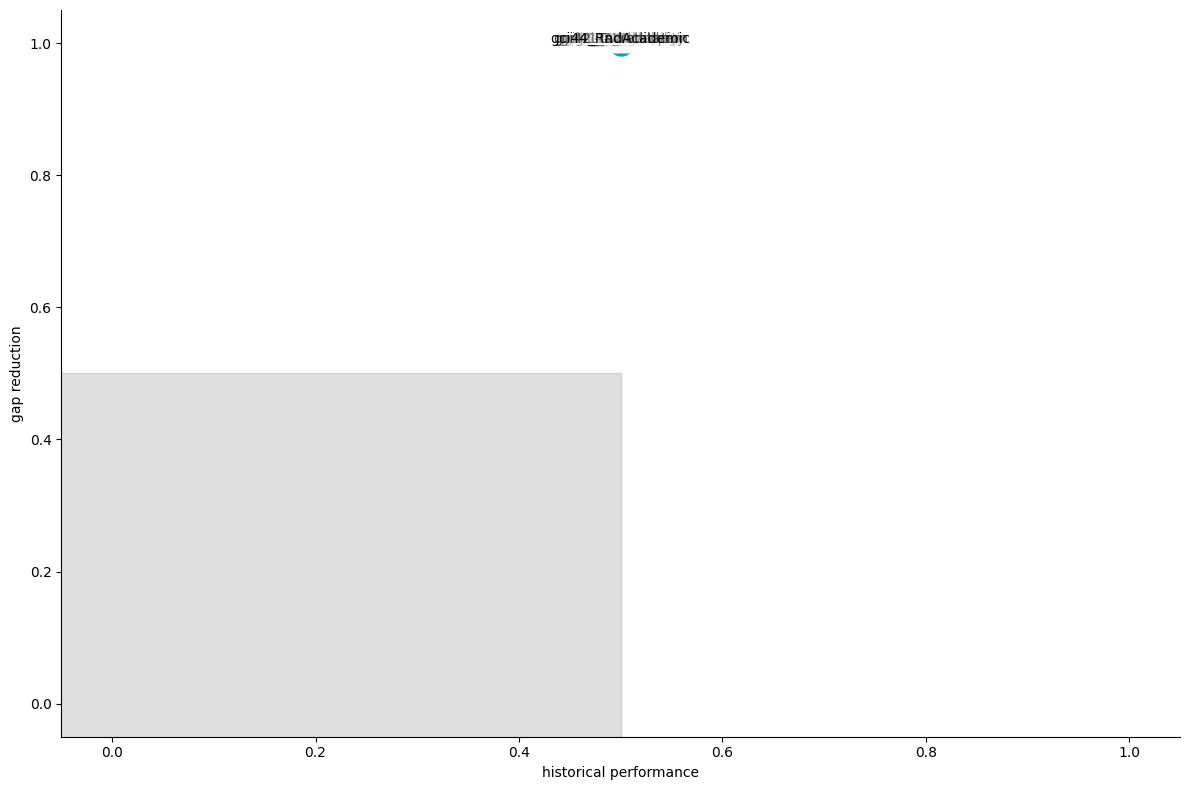

In [16]:
years = [c for c in df_indis.columns if str(c).isnumeric()]
plt.figure(figsize=(12, 8))
plt.fill_between([-.5, .5], [-.5, -.5], [.5, .5], color='grey', alpha=.25)
for index, row in df_indis.iterrows():
    goal = goals[index]
    hist_performance = np.mean(row[years])
    if goal > tsI_baseline[index,T-1]:
        gap_base = goal-tsI_baseline[index,T-1]
        gap_frontier = np.max([0, goal-tsI_frontier[index,T-1]])
        gap_reduction = (gap_base - gap_frontier)/gap_base
        plt.plot(hist_performance, gap_reduction, '.', mec='w', mfc=row.color, markersize=40)
for index, row in df_indis.iterrows():
    goal = goals[index]
    hist_performance = np.mean(row[years])
    if goal > tsI_baseline[index,T-1]:
        gap_base = goal-tsI_baseline[index,T-1]
        gap_frontier = np.max([0, goal-tsI_frontier[index,T-1]])
        gap_reduction = (gap_base - gap_frontier)/gap_base
        txt = plt.text(hist_performance, gap_reduction, row.seriesCode, color='black',
                       horizontalalignment='center')
        txt.set_bbox(dict(facecolor='white', alpha=0.25, edgecolor='white'))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-.05, 1.05)
plt.ylim(-.05, 1.05)
plt.xlabel('historical performance')
plt.ylabel('gap reduction')
plt.tight_layout()